In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-08-11 05:30:40.231828: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 05:30:40.343281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 05:30:40.831672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 05:30:40.834284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 05:30:44.617285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# len(weights_ann_1[0].ravel())

In [4]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [5]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [6]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [7]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [8]:
samp_ann =  ann(hidden = 16, input_shape = 60, output_shape = 1)

In [9]:
weights_ann_1 = samp_ann.get_weights()

In [10]:
h1  = samp_ann.layers[1].output.shape[-1]

In [11]:
h1

16

In [12]:
samp_ann.count_params()

993

In [13]:
hidden_neurons = h1

In [14]:
samp_ann_params = samp_ann.count_params()

In [15]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
#     initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
#     initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(2, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
#     initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
#     initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [16]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [17]:
from scipy.stats import beta

In [18]:
fudging_beta = beta(1,9)

In [19]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
#     model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2,
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2

In [20]:
def forward_operation_test(data1, data2, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
#     model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 
    
    return X_t, initial_ensembles, final_output, model_1, model_2

In [21]:
total_weights = 2*(samp_ann.count_params() + 1 + 1)

In [22]:
reduction = 15

In [23]:
size_ens = total_weights//reduction
# total_weights//reduction

In [24]:
size_ens

132

In [25]:
G_t = [[1, 1]]
G_t = np.array(G_t).T

In [26]:
G_t.shape

(2, 1)

In [27]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2

In [28]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2

In [29]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [30]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [31]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [32]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [33]:
target_dim = 1

In [34]:
lambda_D = 1

In [35]:
from joblib import Parallel, delayed

In [36]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [37]:
# idx = 1

In [38]:
# with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
#     catch_train = pickle.load(f)

In [39]:
# with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
#     catch_test = pickle.load(f)

In [40]:
with open("..//Data//untouched_all_embs_five_fold_5000.pickle", "rb") as f:
    catch_train = pickle.load(f)

In [41]:
# catch_train[-1].shape

In [42]:
import random

In [43]:
from sklearn.decomposition import PCA

In [44]:
size_drugs = 60
size_omics = 30

In [45]:
def prepare_data_train_test(catch_train, idx): 
    item = catch_train[idx]
    a1, a2 = item[0], item[1]
    train_drugs_emb, train_gen_expr_emb, train_dna_methyl_emb, train_gen_mut_emb, train_y = a1
    test_drugs_emb, test_gen_expr_emb, test_dna_methyl_emb, test_gen_mut_emb, test_y = a2
    train_lstm = train_drugs_emb

    test_lstm = test_drugs_emb

    pca = PCA(n_components=size_drugs)
    train_lstm = pca.fit_transform(train_lstm)
    # valid_lstm = pca.transform(valid_lstm)
    test_lstm = pca.transform(test_lstm)
    
    # print(train_lstm.shape)

#     train_doc2vec_gen_expr = train_gen_expr_emb
#     test_doc2vec_gen_expr = test_gen_expr_emb
    
#     pca = PCA(n_components=size_omics)
#     train_doc2vec_gen_expr = pca.fit_transform(train_doc2vec_gen_expr)
#     test_doc2vec_gen_expr = pca.transform(test_doc2vec_gen_expr)
    
    train_doc2vec_gen_mut = train_gen_mut_emb
    test_doc2vec_gen_mut = test_gen_mut_emb
    
    pca = PCA(n_components=size_omics)
    train_doc2vec_gen_mut = pca.fit_transform(train_doc2vec_gen_mut)
    test_doc2vec_gen_mut = pca.transform(test_doc2vec_gen_mut)
    
    train_doc2vec_dna_methyl = train_dna_methyl_emb
    test_doc2vec_dna_methyl = test_dna_methyl_emb
    
    pca = PCA(n_components=size_omics)
    train_doc2vec_dna_methyl = pca.fit_transform(train_doc2vec_dna_methyl)
    test_doc2vec_dna_methyl = pca.transform(test_doc2vec_dna_methyl)
    
    train_drugs = train_lstm
    
    test_drugs = test_lstm
    
    train_omics = np.hstack((train_doc2vec_gen_mut, train_doc2vec_dna_methyl))

    test_omics = np.hstack((test_doc2vec_gen_mut, test_doc2vec_dna_methyl))
    
    
    train_lstm = train_drugs
    test_lstm = test_drugs
    
    train_doc2vec = train_omics
    test_doc2vec = test_omics
    
    return train_lstm, train_doc2vec, test_lstm, test_doc2vec, train_y,  test_y

In [46]:
train_lstm, train_doc2vec, test_lstm, test_doc2vec, train_y,  test_y =  prepare_data_train_test(catch_train, 0)

In [47]:
train_lstm.shape

(4000, 60)

In [48]:
test_lstm.shape

(1000, 60)

In [49]:
# current_test = [data1_test, data2_test, y_test]

In [50]:
from scipy.stats import pearsonr

In [51]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [52]:
batch_size = train_lstm.shape[0]

In [53]:
import random

In [54]:
from tqdm import tqdm_notebook

In [55]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    w1_catch = []
    w2_catch = []

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    best_rmse_train = 10000
    
    train_lstm, train_doc2vec, test_lstm, test_doc2vec, train_y,  test_y =  prepare_data_train_test(catch_train, idx)

    train_idxes = random.sample(range(0, train_lstm.shape[0]), k = train_lstm.shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(train_lstm, train_doc2vec,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
            print("done")
            # data1_train, data2_train, y_train = prepare_data_train(catch_train, chunk)
            
            data1_train, data2_train, y_train =  train_lstm[chunk,:], train_doc2vec[chunk,:], train_y[chunk,:]
            
            initial_ensembles = get_updated_ensemble(data1_train, data2_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
        G_u_train, w1, w2 = get_predictions(train_lstm, train_doc2vec, initial_ensembles, fudging_beta)
        w1_catch.append([w1.mean(), w1.std()])
        w2_catch.append([w2.mean(), w2.std()])
    
        li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
        ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
        width_train = ui_train - li_train
        avg_width_train = width_train.mean(0)[0]
    
        ind_train = (train_y >= li_train) & (train_y <= ui_train)
        coverage_train= ind_train.mean(0)[0]
    
        averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
        rmse_train = np.sqrt(((train_y -averaged_targets_train)**2).mean(0))[0]
        
        pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 train_y.reshape(train_y.shape[0],))
        
        r_train = pearsonr_train.statistic
    
        G_u_test, _, _ = get_predictions_test( test_lstm, test_doc2vec, initial_ensembles)
    

    
        li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
        ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
        width_test = ui_test - li_test
        avg_width_test = width_test.mean(0)[0]
    
        ind_test = (test_y >= li_test) & (test_y <= ui_test)
        coverage_test= ind_test.mean(0)[0]
    
        averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
        rmse_test = np.sqrt(((test_y -averaged_targets_test)**2).mean(0))[0]  
        
        pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 test_y.reshape(test_y.shape[0],))
        
        r_test = pearsonr_test.statistic
            
        train_rmse.append(rmse_train)
            
        test_rmse.append(rmse_test)
            
        if print_true == True: 
            print("Training Coverage, Widths, RMSE, and Pearson R")
            print(coverage_train, avg_width_train, rmse_train, r_train)
            print("Testing Coverage, Widths, RMSE, and Pearson R")
            print(coverage_test, avg_width_test, rmse_test, r_test)
                # print(w1.mean(), w1.std())

        if (rmse_train < best_rmse_train): 
            best_pearsonr_train = r_train
            # print("went here")
            best_train_width_mean = avg_width_train.mean()
            best_train_width = avg_width_train
            # best_smiles_weight = w1.mean()
            best_coverage_train = coverage_train
            best_rmse_train = rmse_train
            best_pearson_r = r_test
            best_test_width = avg_width_test

            best_coverage_test = coverage_test    
            best_rmse_test = rmse_test
            patience = 0
            best_ensembles = initial_ensembles
            best_w1_weight = w1.mean()
            best_w2_weight = w2.mean()
            best_test_preds = averaged_targets_test
            best_li = li_test
            best_ui = ui_test
            best_residuals = (test_y -averaged_targets_test)
            
        else:
            patience = patience + 1
            
        if print_true == True:
            print("Patience is")
            print(patience)
            print('\n')
        
        if patience > threshold:
            
            # print()
            # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
            # print("done for fold" + str(idx), flush = True)
            # print("train_coverage" + str(best_coverage_train), flush = True)
            print("test_coverage" + str(best_coverage_test), flush = True)
            # print("train_width" + str(best_train_width), flush = True)
            print("test_width" + str(best_test_width), flush = True)
            # print("smiles_weight" + str(best_smiles_weight), flush = True)
            # print("rmse_train" + str(best_rmse_train), flush = True)
            print("rmse_test" + str(best_rmse_test), flush = True)
            weights = [best_w1_weight, best_w2_weight]
            print("weights", flush = True)
            print(weights, flush = True)
            print('\n', flush = True)
            # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
            return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals]


In [56]:
threshold = 10

In [57]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, \
best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 2, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = True)

epoch number is 0
done
Training Coverage, Widths, RMSE, and Pearson R
1.0 90.63160905653622 4.467533836369482 -0.13878955264416304
Testing Coverage, Widths, RMSE, and Pearson R
1.0 90.55357799273065 4.469428103518282 -0.18444736190613242
Patience is
0


epoch number is 1
done
Training Coverage, Widths, RMSE, and Pearson R
1.0 27.41997075050299 3.2029253350278384 -0.01584468102569918
Testing Coverage, Widths, RMSE, and Pearson R
1.0 27.390656963911706 3.2477318730907188 -0.08238933146045192
Patience is
0


epoch number is 2
done
Training Coverage, Widths, RMSE, and Pearson R
0.91525 9.144667687138003 2.5358373372554963 0.2580746816027827
Testing Coverage, Widths, RMSE, and Pearson R
0.912 9.077955051979387 2.6039313772608557 0.1616462460319756
Patience is
0


epoch number is 3
done
Training Coverage, Widths, RMSE, and Pearson R
0.84275 5.69689417706762 1.9728217461124484 0.5643822432000497
Testing Coverage, Widths, RMSE, and Pearson R
0.82 5.650752255968716 2.077697904839469 0.501337165

In [58]:
preds_test, _, _ = get_predictions_test( test_lstm, test_doc2vec, best_ensembles)

In [59]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

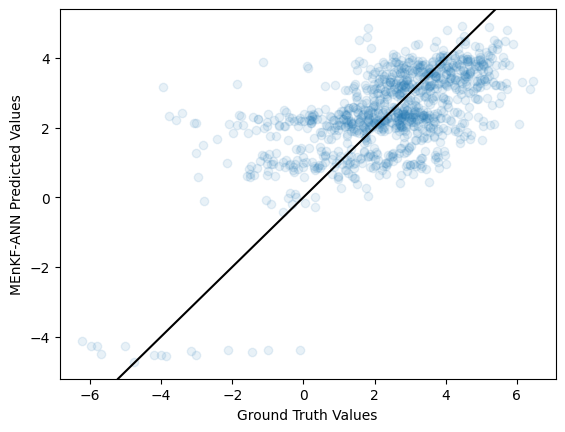

In [60]:
plt.scatter(test_y, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values")
plt.ylabel("MEnKF-ANN Predicted Values")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [61]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,best_w1_weight, best_w2_weight]

In [62]:
items_df = pd.DataFrame(items).T

In [63]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight']

In [64]:
items_df = items_df.T

In [65]:
# items_df.columns = ["Value"]

In [66]:
items_df

,0
best_train_width,4.359568
best_coverage_train,0.889500
best_rmse_train,1.331082
best_test_width,4.334228
best_coverage_test,0.874000
best_rmse_test,1.463760
best_pearson_r,0.644551
best_w1_weight,0.741876
best_w2_weight,0.258124


In [67]:
preds_test.shape

(132, 1000)

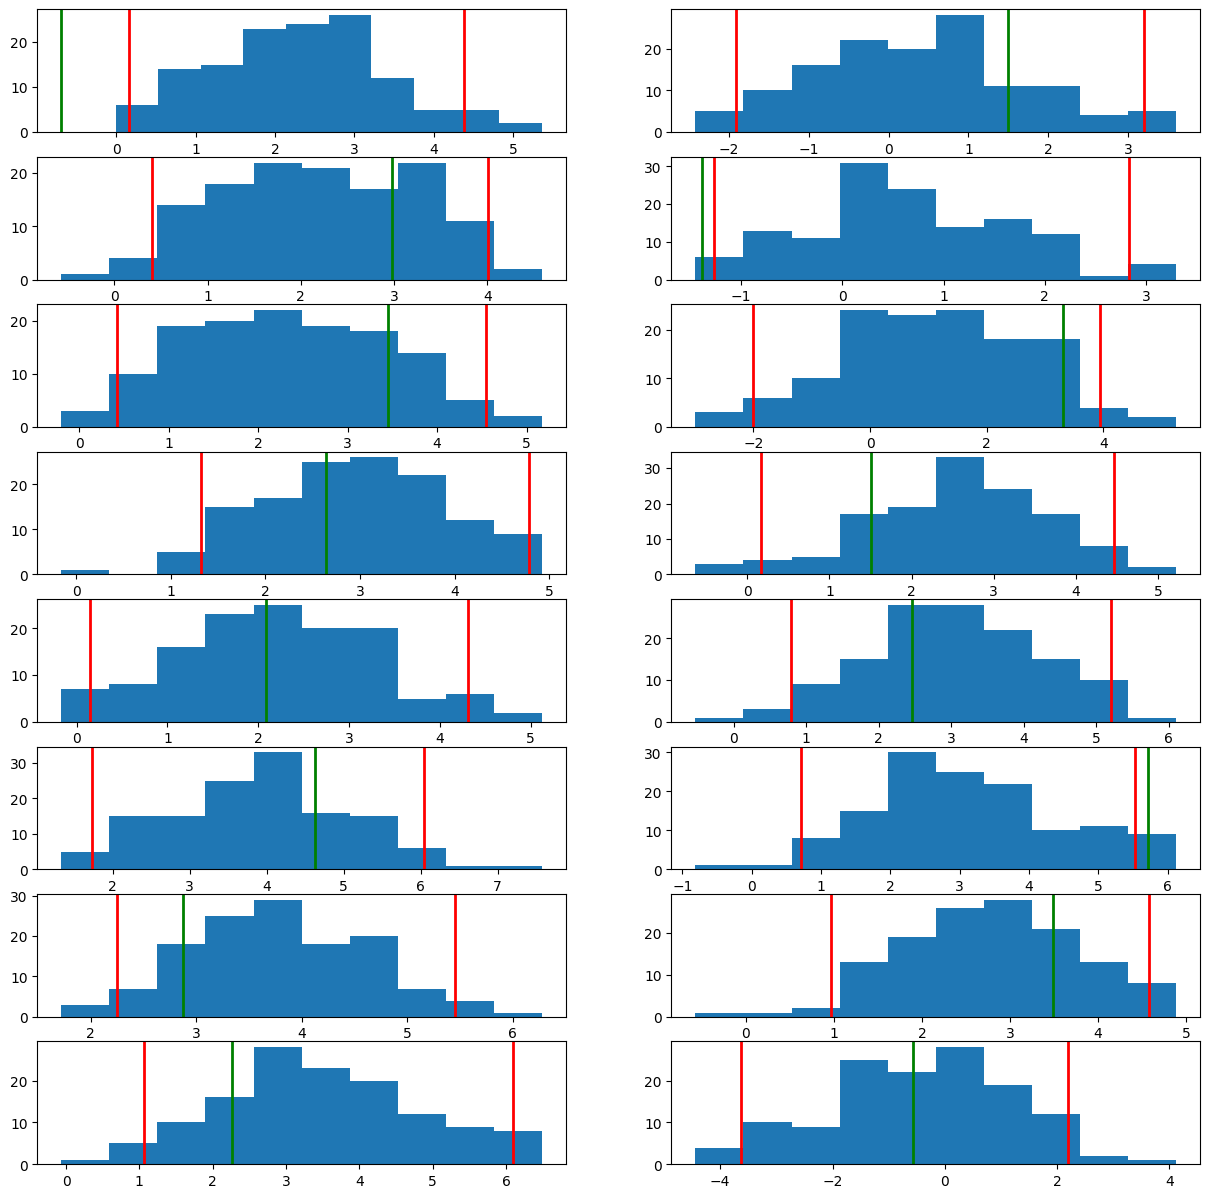

In [68]:
random_idx = random.sample(range(test_y.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = test_y[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


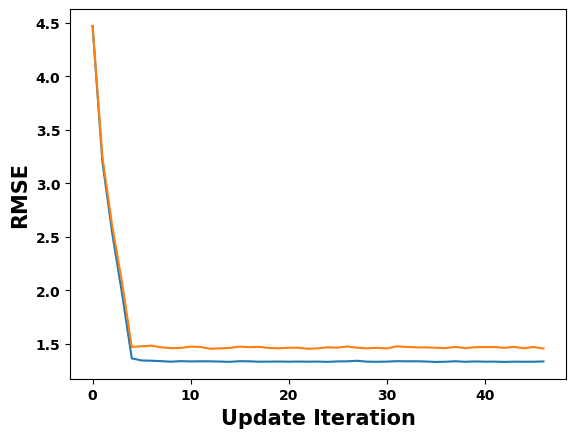

In [69]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.show()

In [70]:
# plt.hist(y_train)
# plt.show()

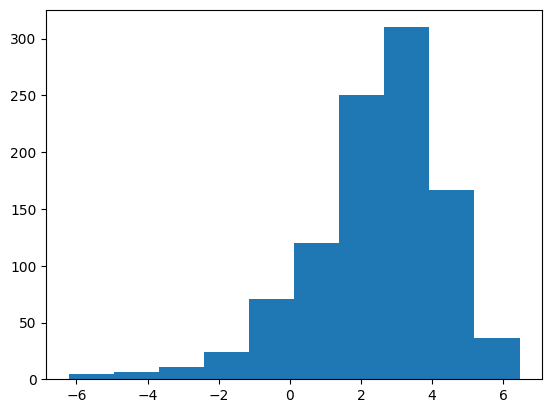

In [71]:
plt.hist(test_y)
plt.show()

In [72]:
catch = Parallel(n_jobs = 10, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 2, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = False) for idx in range(0,5))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
test_coverage0.872
test_width4.193869512336218
rmse_test1.3867099200008373
weights
[0.8297027821595965, 0.17029721784040353]


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
test_coverage0.93
test_width5.385625974349143
rmse_test1.4682589305799647
weights
[0.8768278192760984, 0.12317218072390156]




[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed: 38.3min remaining: 57.5min


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
test_coverage0.878
test_width4.612820421669253
rmse_test1.377253686885174
weights
[0.8372216413315252, 0.1627783586684749]




[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed: 46.6min remaining: 31.1min


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
test_coverage0.964
test_width5.58419613976674
rmse_test1.3591238588170913
weights
[0.6250029721760073, 0.37499702782399263]


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
test_coverage0.895
test_width4.705463958493849
rmse_test1.3455606637104338
weights
[0.8423431830322918, 0.1576568169677082]




[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 55.2min remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 55.2min finished


In [73]:
with open("..//Data//Preds_with_PCA_proper_CV_no_valid_all_but_gen_expr_untouched_five_on_5000_cv.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [74]:
with open("..//Data//Preds_with_PCA_proper_CV_no_valid_all_but_gen_expr_untouched_five_on_5000_cv.pickle", "rb") as f: 
    catch = pickle.load(f)

In [76]:
all_metrics = []
all_weights = []
for i in range(0,5):
    item = catch[i]
    metrics = item[:7]
    weights = item[-8:-6]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [77]:
all_metrics_df = pd.DataFrame(all_metrics)

In [ ]:
# all_metrics_df.head()

In [78]:
all_weights_df = pd.DataFrame(all_weights)

In [79]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [80]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                    "DeepCDR_Drugs", "DeepCDR_Omics"]

In [81]:
all_df.mean()

train_width       4.890891
coverage_train    0.913700
rmse_train        1.350203
test_width        4.896395
coverage_test     0.907800
rmse_test         1.387381
pearson_r         0.692069
DeepCDR_Drugs     0.802220
DeepCDR_Omics     0.197780
dtype: float64

In [82]:
all_df.std()

train_width       0.637564
coverage_train    0.039721
rmse_train        0.010938
test_width        0.575071
coverage_test     0.038681
rmse_test         0.047937
pearson_r         0.036808
DeepCDR_Drugs     0.100701
DeepCDR_Omics     0.100701
dtype: float64